In [6]:
import torch
import utils
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm

from nnsight import LanguageModel

In [7]:
k=10
n_contexts=[1,10,40,70,100,130,160,190,220,250,280,310,340,370,400]
target_count=30
batch_size=16
data_seed=123
loop_seed=56234
model_name="meta-llama/Meta-Llama-3.1-405B"
save_path="./data/markov_mixture/llama/data_405B_v2.pt"

In [8]:
llama = LanguageModel(model_name, device_map="auto")

In [9]:
comma_token_id=llama.tokenizer.encode(",")[1]
relevant_token_ids=torch.tensor([comma_token_id]+[llama.tokenizer.encode(s)[1] for s in "0123456789"],dtype=torch.int64)
relevant_token_ids

tensor([11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [10]:
Ts_collected=[]
current_Ts=torch.full((len(n_contexts),k,k),fill_value=torch.nan)
prefix="Continue the given sequence of digits between 0 and 9. The sequence comes from a Markov process. The sequence is as follows:\n"
token_ids_prefix=llama.tokenizer.encode(prefix)
i_sequence_start=len(token_ids_prefix)
np.random.seed(data_seed)
rss=np.random.randint(1000000,size=target_count)#this should be enough
generator=np.random.RandomState(loop_seed)
T_stars={}

i_done=0
while len(Ts_collected)<target_count:
    rs=rss[i_done]
    dataset_star=utils.get_markov_dataset_single(k=k,l=n_contexts[-1]+5,structured=False,random_state=rs)
    T_stars[i_done]=torch.tensor(dataset_star.T)
    np.random.seed(generator.randint(1000000))#generator set outside so each loop is different
    seqs=[]
    positions=[]
    token_ids=[]
    for _ in range(batch_size):
        seq=dataset_star.get_data()
        seqs.append(seq)
        data_str=",".join(seq.numpy().astype(str))
        data_str=prefix+data_str
        token_ids_=llama.tokenizer.encode(data_str,return_tensors="pt")
        token_ids.append(token_ids_)
    seqs=torch.stack(seqs,dim=0)
    print("Seqs shape:",seqs.shape)
    token_ids=torch.cat(token_ids,dim=0)
    print("Token ids shape:",token_ids.shape)
    
    with llama.trace(token_ids, remote=True) as runner:
        logits=llama.output.logits
        relevant_logits=logits[:,:,relevant_token_ids].save()
    print("Relevant logits shape:",relevant_logits.shape)
    
    positions=np.arange(i_sequence_start+1,token_ids.shape[1],2).tolist()#comma positions
    relevant_logits=relevant_logits[:,positions,:]
    comma_probs=torch.nn.functional.softmax(relevant_logits,dim=-1)[:,:,0]
    if torch.any(comma_probs>1e-2):
        print("Found a comma, skipping")
        continue
    probss=torch.nn.functional.softmax(relevant_logits[:,:,1:],dim=-1)
    print("Probss shape:",probss.shape)
        
    for i_n_context,n_context in enumerate(n_contexts):
        for seq,probs in zip(seqs,probss):
            last_state=seq[n_context-1]
            val=current_Ts[i_n_context,last_state,:]
            if torch.isnan(val[0]):
                current_Ts[i_n_context,last_state,:]=probs[n_context-1,:]
    #check if Ts are filled
    if torch.all(~torch.isnan(current_Ts)):
        print("Ts are filled, collecting")
        Ts_collected.append(current_Ts.clone())
        current_Ts[...]=torch.nan
        i_done+=1
    print(f"Collected {len(Ts_collected)} Tss")
Ts_collected=torch.stack(Ts_collected)
T_stars=torch.stack([T_stars[i] for i in range(target_count)],dim=0)
Ts_collected.shape,T_stars.shape

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 15:52:21,432 MainProcess nnsight_remote INFO     ae818b8e-d443-484d-98df-aaef4fe220b5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:52:21,477 MainProcess nnsight_remote INFO     ae818b8e-d443-484d-98df-aaef4fe220b5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:54:54,535 MainProcess nnsight_remote INFO     ae818b8e-d443-484d-98df-aaef4fe220b5 - RUNNING: Your job has started running.
2024-09-14 15:58:13,181 MainProcess nnsight_remote INFO     ae818b8e-d443-484d-98df-aaef4fe220b5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 15:58:14,418 MainProcess nnsight_remote INFO     7fe56dcd-bffb-4a16-832f-37f5674a211c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 15:58:14,446 MainProcess nnsight_remote INFO     7fe56dcd-bffb-4a16-832f-37f5674a211c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 15:58:14,473 MainProcess nnsight_remote INFO     7fe56dcd-bffb-4a16-832f-37f5674a211c - RUNNING: Your job has started running.
2024-09-14 16:01:31,040 MainProcess nnsight_remote INFO     7fe56dcd-bffb-4a16-832f-37f5674a211c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:01:32,131 MainProcess nnsight_remote INFO     bd149aef-434f-4c94-9acd-d2d2e9741351 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:01:32,154 MainProcess nnsight_remote INFO     bd149aef-434f-4c94-9acd-d2d2e9741351 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:01:32,174 MainProcess nnsight_remote INFO     bd149aef-434f-4c94-9acd-d2d2e9741351 - RUNNING: Your job has started running.
2024-09-14 16:04:49,857 MainProcess nnsight_remote INFO     bd149aef-434f-4c94-9acd-d2d2e9741351 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:04:50,933 MainProcess nnsight_remote INFO     d83282a6-a6b3-482f-94f2-733f0c5ed997 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:04:50,970 MainProcess nnsight_remote INFO     d83282a6-a6b3-482f-94f2-733f0c5ed997 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:04:50,980 MainProcess nnsight_remote INFO     d83282a6-a6b3-482f-94f2-733f0c5ed997 - RUNNING: Your job has started running.
2024-09-14 16:08:08,060 MainProcess nnsight_remote INFO     d83282a6-a6b3-482f-94f2-733f0c5ed997 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:08:09,200 MainProcess nnsight_remote INFO     6c180137-38ac-441d-aac7-ea928847b7b0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:08:09,255 MainProcess nnsight_remote INFO     6c180137-38ac-441d-aac7-ea928847b7b0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:08:09,267 MainProcess nnsight_remote INFO     6c180137-38ac-441d-aac7-ea928847b7b0 - RUNNING: Your job has started running.
2024-09-14 16:11:25,059 MainProcess nnsight_remote INFO     6c180137-38ac-441d-aac7-ea928847b7b0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:11:26,175 MainProcess nnsight_remote INFO     4937f017-9c66-4eae-bcdf-99f11398df5e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:11:26,192 MainProcess nnsight_remote INFO     4937f017-9c66-4eae-bcdf-99f11398df5e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:11:26,206 MainProcess nnsight_remote INFO     4937f017-9c66-4eae-bcdf-99f11398df5e - RUNNING: Your job has started running.
2024-09-14 16:14:45,635 MainProcess nnsight_remote INFO     4937f017-9c66-4eae-bcdf-99f11398df5e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:14:47,046 MainProcess nnsight_remote INFO     94fa349b-4196-4e8d-9d46-819aaf09c883 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:14:47,085 MainProcess nnsight_remote INFO     94fa349b-4196-4e8d-9d46-819aaf09c883 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:14:47,103 MainProcess nnsight_remote INFO     94fa349b-4196-4e8d-9d46-819aaf09c883 - RUNNING: Your job has started running.
2024-09-14 16:18:00,181 MainProcess nnsight_remote INFO     94fa349b-4196-4e8d-9d46-819aaf09c883 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:18:02,042 MainProcess nnsight_remote INFO     02acf247-4954-479f-b4c5-12149d152a80 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:18:02,080 MainProcess nnsight_remote INFO     02acf247-4954-479f-b4c5-12149d152a80 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:18:02,092 MainProcess nnsight_remote INFO     02acf247-4954-479f-b4c5-12149d152a80 - RUNNING: Your job has started running.
2024-09-14 16:21:17,382 MainProcess nnsight_remote INFO     02acf247-4954-479f-b4c5-12149d152a80 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:21:18,737 MainProcess nnsight_remote INFO     168827cd-7f8c-46c1-8b6c-a002e4ad03e5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:21:18,770 MainProcess nnsight_remote INFO     168827cd-7f8c-46c1-8b6c-a002e4ad03e5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:21:18,781 MainProcess nnsight_remote INFO     168827cd-7f8c-46c1-8b6c-a002e4ad03e5 - RUNNING: Your job has started running.
2024-09-14 16:24:39,685 MainProcess nnsight_remote INFO     168827cd-7f8c-46c1-8b6c-a002e4ad03e5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:24:41,134 MainProcess nnsight_remote INFO     ee75c949-a5a3-443b-b0e4-484b3e7344b9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:24:41,158 MainProcess nnsight_remote INFO     ee75c949-a5a3-443b-b0e4-484b3e7344b9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:24:41,177 MainProcess nnsight_remote INFO     ee75c949-a5a3-443b-b0e4-484b3e7344b9 - RUNNING: Your job has started running.
2024-09-14 16:28:03,320 MainProcess nnsight_remote INFO     ee75c949-a5a3-443b-b0e4-484b3e7344b9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:28:04,944 MainProcess nnsight_remote INFO     d6f5575f-aaf3-45b7-8daf-c376ca4b3738 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:28:04,986 MainProcess nnsight_remote INFO     d6f5575f-aaf3-45b7-8daf-c376ca4b3738 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:28:05,090 MainProcess nnsight_remote INFO     d6f5575f-aaf3-45b7-8daf-c376ca4b3738 - RUNNING: Your job has started running.
2024-09-14 16:31:20,835 MainProcess nnsight_remote INFO     d6f5575f-aaf3-45b7-8daf-c376ca4b3738 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:31:22,260 MainProcess nnsight_remote INFO     b4d4a36b-d1ee-4027-941b-4c74b26b72e2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:31:22,292 MainProcess nnsight_remote INFO     b4d4a36b-d1ee-4027-941b-4c74b26b72e2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:31:24,202 MainProcess nnsight_remote INFO     b4d4a36b-d1ee-4027-941b-4c74b26b72e2 - RUNNING: Your job has started running.
2024-09-14 16:34:42,635 MainProcess nnsight_remote INFO     b4d4a36b-d1ee-4027-941b-4c74b26b72e2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:34:43,957 MainProcess nnsight_remote INFO     34c89856-8050-4826-bcfd-11f9e586d2bb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:34:44,011 MainProcess nnsight_remote INFO     34c89856-8050-4826-bcfd-11f9e586d2bb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:34:45,785 MainProcess nnsight_remote INFO     34c89856-8050-4826-bcfd-11f9e586d2bb - RUNNING: Your job has started running.
2024-09-14 16:38:02,946 MainProcess nnsight_remote INFO     34c89856-8050-4826-bcfd-11f9e586d2bb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:38:04,235 MainProcess nnsight_remote INFO     0a09ec8b-337d-40fb-8afd-98e19cf49883 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:38:04,262 MainProcess nnsight_remote INFO     0a09ec8b-337d-40fb-8afd-98e19cf49883 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:38:08,039 MainProcess nnsight_remote INFO     0a09ec8b-337d-40fb-8afd-98e19cf49883 - RUNNING: Your job has started running.
2024-09-14 16:41:28,808 MainProcess nnsight_remote INFO     0a09ec8b-337d-40fb-8afd-98e19cf49883 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:41:30,381 MainProcess nnsight_remote INFO     8f6a815d-9397-4a1d-b6f7-2720b651e060 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:41:30,441 MainProcess nnsight_remote INFO     8f6a815d-9397-4a1d-b6f7-2720b651e060 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:41:34,045 MainProcess nnsight_remote INFO     8f6a815d-9397-4a1d-b6f7-2720b651e060 - RUNNING: Your job has started running.
2024-09-14 16:44:53,871 MainProcess nnsight_remote INFO     8f6a815d-9397-4a1d-b6f7-2720b651e060 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:44:55,121 MainProcess nnsight_remote INFO     1a7810cd-fb8e-4ddc-884d-0c6e6bd3f847 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:44:55,169 MainProcess nnsight_remote INFO     1a7810cd-fb8e-4ddc-884d-0c6e6bd3f847 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:44:58,831 MainProcess nnsight_remote INFO     1a7810cd-fb8e-4ddc-884d-0c6e6bd3f847 - RUNNING: Your job has started running.
2024-09-14 16:48:20,029 MainProcess nnsight_remote INFO     1a7810cd-fb8e-4ddc-884d-0c6e6bd3f847 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:48:21,287 MainProcess nnsight_remote INFO     3d1e47c7-d77f-44e3-9a7d-b31ab1daf631 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:48:21,336 MainProcess nnsight_remote INFO     3d1e47c7-d77f-44e3-9a7d-b31ab1daf631 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:48:23,011 MainProcess nnsight_remote INFO     3d1e47c7-d77f-44e3-9a7d-b31ab1daf631 - RUNNING: Your job has started running.
2024-09-14 16:51:41,433 MainProcess nnsight_remote INFO     3d1e47c7-d77f-44e3-9a7d-b31ab1daf631 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:51:42,870 MainProcess nnsight_remote INFO     f68ea7a4-cfb5-4e88-9126-00c82a7da665 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:51:42,900 MainProcess nnsight_remote INFO     f68ea7a4-cfb5-4e88-9126-00c82a7da665 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:51:44,412 MainProcess nnsight_remote INFO     f68ea7a4-cfb5-4e88-9126-00c82a7da665 - RUNNING: Your job has started running.
2024-09-14 16:55:03,093 MainProcess nnsight_remote INFO     f68ea7a4-cfb5-4e88-9126-00c82a7da665 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:55:04,416 MainProcess nnsight_remote INFO     009a507b-fca8-461b-b832-14362439b7af - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:55:04,446 MainProcess nnsight_remote INFO     009a507b-fca8-461b-b832-14362439b7af - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:55:06,159 MainProcess nnsight_remote INFO     009a507b-fca8-461b-b832-14362439b7af - RUNNING: Your job has started running.
2024-09-14 16:58:26,515 MainProcess nnsight_remote INFO     009a507b-fca8-461b-b832-14362439b7af - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 16:58:27,781 MainProcess nnsight_remote INFO     fb33888d-33db-4af9-9b01-5a722b91fe26 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 16:58:27,806 MainProcess nnsight_remote INFO     fb33888d-33db-4af9-9b01-5a722b91fe26 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 16:58:31,391 MainProcess nnsight_remote INFO     fb33888d-33db-4af9-9b01-5a722b91fe26 - RUNNING: Your job has started running.
2024-09-14 17:01:49,062 MainProcess nnsight_remote INFO     fb33888d-33db-4af9-9b01-5a722b91fe26 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:01:50,716 MainProcess nnsight_remote INFO     d4c5ccdf-4754-4203-bee5-ccabd7aadab9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:01:50,749 MainProcess nnsight_remote INFO     d4c5ccdf-4754-4203-bee5-ccabd7aadab9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:01:53,684 MainProcess nnsight_remote INFO     d4c5ccdf-4754-4203-bee5-ccabd7aadab9 - RUNNING: Your job has started running.
2024-09-14 17:05:11,679 MainProcess nnsight_remote INFO     d4c5ccdf-4754-4203-bee5-ccabd7aadab9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:05:12,976 MainProcess nnsight_remote INFO     fae42315-0cc1-450b-a396-8956b5519af0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:05:13,029 MainProcess nnsight_remote INFO     fae42315-0cc1-450b-a396-8956b5519af0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:05:34,571 MainProcess nnsight_remote INFO     fae42315-0cc1-450b-a396-8956b5519af0 - RUNNING: Your job has started running.
2024-09-14 17:08:53,398 MainProcess nnsight_remote INFO     fae42315-0cc1-450b-a396-8956b5519af0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:08:54,664 MainProcess nnsight_remote INFO     c60b8bc6-62ba-454e-9790-b866af0b8988 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:08:54,696 MainProcess nnsight_remote INFO     c60b8bc6-62ba-454e-9790-b866af0b8988 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:09:15,631 MainProcess nnsight_remote INFO     c60b8bc6-62ba-454e-9790-b866af0b8988 - RUNNING: Your job has started running.
2024-09-14 17:12:37,463 MainProcess nnsight_remote INFO     c60b8bc6-62ba-454e-9790-b866af0b8988 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:12:38,618 MainProcess nnsight_remote INFO     388e2af4-4726-4f0f-8466-a2b386ea51a6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:12:38,667 MainProcess nnsight_remote INFO     388e2af4-4726-4f0f-8466-a2b386ea51a6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:12:42,420 MainProcess nnsight_remote INFO     388e2af4-4726-4f0f-8466-a2b386ea51a6 - RUNNING: Your job has started running.
2024-09-14 17:16:02,589 MainProcess nnsight_remote INFO     388e2af4-4726-4f0f-8466-a2b386ea51a6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:16:03,863 MainProcess nnsight_remote INFO     199a13a6-c00f-4108-8b2e-4166cdfabd78 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:16:03,913 MainProcess nnsight_remote INFO     199a13a6-c00f-4108-8b2e-4166cdfabd78 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:16:07,309 MainProcess nnsight_remote INFO     199a13a6-c00f-4108-8b2e-4166cdfabd78 - RUNNING: Your job has started running.
2024-09-14 17:19:27,778 MainProcess nnsight_remote INFO     199a13a6-c00f-4108-8b2e-4166cdfabd78 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:19:29,205 MainProcess nnsight_remote INFO     67a7ca01-85ad-4c4e-8e90-7712cb6f5bf6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:19:29,254 MainProcess nnsight_remote INFO     67a7ca01-85ad-4c4e-8e90-7712cb6f5bf6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:19:30,799 MainProcess nnsight_remote INFO     67a7ca01-85ad-4c4e-8e90-7712cb6f5bf6 - RUNNING: Your job has started running.
2024-09-14 17:22:46,815 MainProcess nnsight_remote INFO     67a7ca01-85ad-4c4e-8e90-7712cb6f5bf6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:22:48,190 MainProcess nnsight_remote INFO     94ed06d2-ec10-4a6b-bed9-3264f1b240b6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:22:48,216 MainProcess nnsight_remote INFO     94ed06d2-ec10-4a6b-bed9-3264f1b240b6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:22:51,761 MainProcess nnsight_remote INFO     94ed06d2-ec10-4a6b-bed9-3264f1b240b6 - RUNNING: Your job has started running.
2024-09-14 17:26:02,978 MainProcess nnsight_remote INFO     94ed06d2-ec10-4a6b-bed9-3264f1b240b6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:26:04,162 MainProcess nnsight_remote INFO     c4accf3a-dd5f-47cb-af03-a66b57003eb6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:26:04,194 MainProcess nnsight_remote INFO     c4accf3a-dd5f-47cb-af03-a66b57003eb6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:26:19,814 MainProcess nnsight_remote INFO     c4accf3a-dd5f-47cb-af03-a66b57003eb6 - RUNNING: Your job has started running.
2024-09-14 17:29:31,591 MainProcess nnsight_remote INFO     c4accf3a-dd5f-47cb-af03-a66b57003eb6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:29:33,066 MainProcess nnsight_remote INFO     ba13693a-6d0c-46b7-aa41-d4fb68d21d89 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:29:33,119 MainProcess nnsight_remote INFO     ba13693a-6d0c-46b7-aa41-d4fb68d21d89 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:29:50,156 MainProcess nnsight_remote INFO     ba13693a-6d0c-46b7-aa41-d4fb68d21d89 - RUNNING: Your job has started running.
2024-09-14 17:33:03,135 MainProcess nnsight_remote INFO     ba13693a-6d0c-46b7-aa41-d4fb68d21d89 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:33:04,607 MainProcess nnsight_remote INFO     a7066dd0-06c7-4967-b71b-3adfad683897 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:33:04,639 MainProcess nnsight_remote INFO     a7066dd0-06c7-4967-b71b-3adfad683897 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:33:21,142 MainProcess nnsight_remote INFO     a7066dd0-06c7-4967-b71b-3adfad683897 - RUNNING: Your job has started running.
2024-09-14 17:36:42,192 MainProcess nnsight_remote INFO     a7066dd0-06c7-4967-b71b-3adfad683897 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:36:43,666 MainProcess nnsight_remote INFO     8b80cdc9-0ec8-4867-9c17-cd776c62b121 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:43,698 MainProcess nnsight_remote INFO     8b80cdc9-0ec8-4867-9c17-cd776c62b121 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:45,322 MainProcess nnsight_remote INFO     8b80cdc9-0ec8-4867-9c17-cd776c62b121 - RUNNING: Your job has started running.
2024-09-14 17:39:58,988 MainProcess nnsight_remote INFO     8b80cdc9-0ec8-4867-9c17-cd776c62b121 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:40:00,259 MainProcess nnsight_remote INFO     dc840b7e-1271-4872-96cc-b272b30d6289 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:00,279 MainProcess nnsight_remote INFO     dc840b7e-1271-4872-96cc-b272b30d6289 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:01,336 MainProcess nnsight_remote INFO     dc840b7e-1271-4872-96cc-b272b30d6289 - RUNNING: Your job has started running.
2024-09-14 17:43:16,344 MainProcess nnsight_remote INFO     dc840b7e-1271-4872-96cc-b272b30d6289 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:43:17,736 MainProcess nnsight_remote INFO     6eb8320f-804f-41d0-bf4a-03f728ae8434 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:17,836 MainProcess nnsight_remote INFO     6eb8320f-804f-41d0-bf4a-03f728ae8434 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:31,300 MainProcess nnsight_remote INFO     6eb8320f-804f-41d0-bf4a-03f728ae8434 - RUNNING: Your job has started running.
2024-09-14 17:46:46,423 MainProcess nnsight_remote INFO     6eb8320f-804f-41d0-bf4a-03f728ae8434 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:46:47,573 MainProcess nnsight_remote INFO     61d5fb07-93da-4c01-b10a-e96f09b03dda - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:47,601 MainProcess nnsight_remote INFO     61d5fb07-93da-4c01-b10a-e96f09b03dda - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:52,197 MainProcess nnsight_remote INFO     61d5fb07-93da-4c01-b10a-e96f09b03dda - RUNNING: Your job has started running.
2024-09-14 17:50:09,670 MainProcess nnsight_remote INFO     61d5fb07-93da-4c01-b10a-e96f09b03dda - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:50:11,080 MainProcess nnsight_remote INFO     dd0720c3-c1b3-43cc-ae74-f8bd1e4ead4d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:11,109 MainProcess nnsight_remote INFO     dd0720c3-c1b3-43cc-ae74-f8bd1e4ead4d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:22,499 MainProcess nnsight_remote INFO     dd0720c3-c1b3-43cc-ae74-f8bd1e4ead4d - RUNNING: Your job has started running.
2024-09-14 17:53:37,201 MainProcess nnsight_remote INFO     dd0720c3-c1b3-43cc-ae74-f8bd1e4ead4d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:53:38,449 MainProcess nnsight_remote INFO     83d2a55d-affd-4f7c-9ed5-298536b4e76a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:38,486 MainProcess nnsight_remote INFO     83d2a55d-affd-4f7c-9ed5-298536b4e76a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:49,075 MainProcess nnsight_remote INFO     83d2a55d-affd-4f7c-9ed5-298536b4e76a - RUNNING: Your job has started running.
2024-09-14 17:57:05,164 MainProcess nnsight_remote INFO     83d2a55d-affd-4f7c-9ed5-298536b4e76a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 17:57:06,521 MainProcess nnsight_remote INFO     33270bdb-cea4-4b32-99e6-485c9e2cb688 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:57:06,549 MainProcess nnsight_remote INFO     33270bdb-cea4-4b32-99e6-485c9e2cb688 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:57:06,562 MainProcess nnsight_remote INFO     33270bdb-cea4-4b32-99e6-485c9e2cb688 - RUNNING: Your job has started running.
2024-09-14 18:00:17,413 MainProcess nnsight_remote INFO     33270bdb-cea4-4b32-99e6-485c9e2cb688 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:00:19,193 MainProcess nnsight_remote INFO     c4a00bd9-9ede-4abc-8b40-1f0ef226323a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:00:19,223 MainProcess nnsight_remote INFO     c4a00bd9-9ede-4abc-8b40-1f0ef226323a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:00:19,622 MainProcess nnsight_remote INFO     c4a00bd9-9ede-4abc-8b40-1f0ef226323a - RUNNING: Your job has started running.
2024-09-14 18:03:29,998 MainProcess nnsight_remote INFO     c4a00bd9-9ede-4abc-8b40-1f0ef226323a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:03:32,617 MainProcess nnsight_remote INFO     ce485db6-c2a2-4dfc-8adf-bcb86d81575e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:03:32,641 MainProcess nnsight_remote INFO     ce485db6-c2a2-4dfc-8adf-bcb86d81575e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:03:32,661 MainProcess nnsight_remote INFO     ce485db6-c2a2-4dfc-8adf-bcb86d81575e - RUNNING: Your job has started running.
2024-09-14 18:06:45,526 MainProcess nnsight_remote INFO     ce485db6-c2a2-4dfc-8adf-bcb86d81575e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:06:47,094 MainProcess nnsight_remote INFO     95db7ab5-bedb-47f0-b448-230d1d0f6fab - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:06:47,138 MainProcess nnsight_remote INFO     95db7ab5-bedb-47f0-b448-230d1d0f6fab - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:06:47,149 MainProcess nnsight_remote INFO     95db7ab5-bedb-47f0-b448-230d1d0f6fab - RUNNING: Your job has started running.
2024-09-14 18:10:00,695 MainProcess nnsight_remote INFO     95db7ab5-bedb-47f0-b448-230d1d0f6fab - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:10:02,052 MainProcess nnsight_remote INFO     1f2329d2-727b-49a8-8d03-de33b288542a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:10:02,084 MainProcess nnsight_remote INFO     1f2329d2-727b-49a8-8d03-de33b288542a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:10:02,100 MainProcess nnsight_remote INFO     1f2329d2-727b-49a8-8d03-de33b288542a - RUNNING: Your job has started running.
2024-09-14 18:13:17,678 MainProcess nnsight_remote INFO     1f2329d2-727b-49a8-8d03-de33b288542a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:13:19,208 MainProcess nnsight_remote INFO     e10df87e-991a-433f-a8fc-539cbd705375 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:13:19,238 MainProcess nnsight_remote INFO     e10df87e-991a-433f-a8fc-539cbd705375 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:13:19,256 MainProcess nnsight_remote INFO     e10df87e-991a-433f-a8fc-539cbd705375 - RUNNING: Your job has started running.
2024-09-14 18:16:33,097 MainProcess nnsight_remote INFO     e10df87e-991a-433f-a8fc-539cbd705375 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:16:34,453 MainProcess nnsight_remote INFO     064cbe5e-cbca-44d0-82ee-cd384f35e175 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:16:34,478 MainProcess nnsight_remote INFO     064cbe5e-cbca-44d0-82ee-cd384f35e175 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:16:35,106 MainProcess nnsight_remote INFO     064cbe5e-cbca-44d0-82ee-cd384f35e175 - RUNNING: Your job has started running.
2024-09-14 18:19:48,902 MainProcess nnsight_remote INFO     064cbe5e-cbca-44d0-82ee-cd384f35e175 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:19:50,591 MainProcess nnsight_remote INFO     ced0b683-bfee-405e-afbf-ee159a6a6a38 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:19:50,840 MainProcess nnsight_remote INFO     ced0b683-bfee-405e-afbf-ee159a6a6a38 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:19:51,113 MainProcess nnsight_remote INFO     ced0b683-bfee-405e-afbf-ee159a6a6a38 - RUNNING: Your job has started running.
2024-09-14 18:23:06,558 MainProcess nnsight_remote INFO     ced0b683-bfee-405e-afbf-ee159a6a6a38 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:23:07,831 MainProcess nnsight_remote INFO     81a79e94-bdb5-446b-b783-4c1121a3ec6c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:23:07,870 MainProcess nnsight_remote INFO     81a79e94-bdb5-446b-b783-4c1121a3ec6c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:23:07,887 MainProcess nnsight_remote INFO     81a79e94-bdb5-446b-b783-4c1121a3ec6c - RUNNING: Your job has started running.
2024-09-14 18:26:25,136 MainProcess nnsight_remote INFO     81a79e94-bdb5-446b-b783-4c1121a3ec6c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:26:26,379 MainProcess nnsight_remote INFO     b611a497-ef6e-459e-8d90-08d65299e8c5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:26:26,426 MainProcess nnsight_remote INFO     b611a497-ef6e-459e-8d90-08d65299e8c5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:26:26,440 MainProcess nnsight_remote INFO     b611a497-ef6e-459e-8d90-08d65299e8c5 - RUNNING: Your job has started running.
2024-09-14 18:29:37,776 MainProcess nnsight_remote INFO     b611a497-ef6e-459e-8d90-08d65299e8c5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:29:39,051 MainProcess nnsight_remote INFO     a3c71383-e628-4a8e-9684-a7921502c7f9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:29:39,095 MainProcess nnsight_remote INFO     a3c71383-e628-4a8e-9684-a7921502c7f9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:29:39,106 MainProcess nnsight_remote INFO     a3c71383-e628-4a8e-9684-a7921502c7f9 - RUNNING: Your job has started running.
2024-09-14 18:32:48,500 MainProcess nnsight_remote INFO     a3c71383-e628-4a8e-9684-a7921502c7f9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:32:50,083 MainProcess nnsight_remote INFO     4ee7881a-f117-4be0-9eee-bda6f0a11821 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:32:50,110 MainProcess nnsight_remote INFO     4ee7881a-f117-4be0-9eee-bda6f0a11821 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:32:50,129 MainProcess nnsight_remote INFO     4ee7881a-f117-4be0-9eee-bda6f0a11821 - RUNNING: Your job has started running.
2024-09-14 18:36:00,939 MainProcess nnsight_remote INFO     4ee7881a-f117-4be0-9eee-bda6f0a11821 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:36:02,302 MainProcess nnsight_remote INFO     8ba4d777-eb40-4096-83cf-2cf10f9f7358 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:36:02,330 MainProcess nnsight_remote INFO     8ba4d777-eb40-4096-83cf-2cf10f9f7358 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:36:02,346 MainProcess nnsight_remote INFO     8ba4d777-eb40-4096-83cf-2cf10f9f7358 - RUNNING: Your job has started running.
2024-09-14 18:39:13,137 MainProcess nnsight_remote INFO     8ba4d777-eb40-4096-83cf-2cf10f9f7358 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:39:14,794 MainProcess nnsight_remote INFO     42be419c-4a36-419e-95fa-7a074beec27b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:39:14,830 MainProcess nnsight_remote INFO     42be419c-4a36-419e-95fa-7a074beec27b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:39:14,844 MainProcess nnsight_remote INFO     42be419c-4a36-419e-95fa-7a074beec27b - RUNNING: Your job has started running.
2024-09-14 18:42:25,017 MainProcess nnsight_remote INFO     42be419c-4a36-419e-95fa-7a074beec27b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:42:26,384 MainProcess nnsight_remote INFO     cb99d792-b8d9-4850-86e2-0723eec6f4b2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:42:26,412 MainProcess nnsight_remote INFO     cb99d792-b8d9-4850-86e2-0723eec6f4b2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:42:26,427 MainProcess nnsight_remote INFO     cb99d792-b8d9-4850-86e2-0723eec6f4b2 - RUNNING: Your job has started running.
2024-09-14 18:45:35,802 MainProcess nnsight_remote INFO     cb99d792-b8d9-4850-86e2-0723eec6f4b2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:45:37,123 MainProcess nnsight_remote INFO     24da4ab9-db2f-4d32-ba93-d18465e0eac5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:45:37,147 MainProcess nnsight_remote INFO     24da4ab9-db2f-4d32-ba93-d18465e0eac5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:45:37,161 MainProcess nnsight_remote INFO     24da4ab9-db2f-4d32-ba93-d18465e0eac5 - RUNNING: Your job has started running.
2024-09-14 18:48:48,828 MainProcess nnsight_remote INFO     24da4ab9-db2f-4d32-ba93-d18465e0eac5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:48:50,089 MainProcess nnsight_remote INFO     d984cbdf-8e5d-4c40-8ff9-c3bb57a01cf6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:48:50,139 MainProcess nnsight_remote INFO     d984cbdf-8e5d-4c40-8ff9-c3bb57a01cf6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:48:50,154 MainProcess nnsight_remote INFO     d984cbdf-8e5d-4c40-8ff9-c3bb57a01cf6 - RUNNING: Your job has started running.
2024-09-14 18:51:59,784 MainProcess nnsight_remote INFO     d984cbdf-8e5d-4c40-8ff9-c3bb57a01cf6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:52:01,566 MainProcess nnsight_remote INFO     940cb714-d270-4529-a1e0-0eae026dd205 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:52:01,603 MainProcess nnsight_remote INFO     940cb714-d270-4529-a1e0-0eae026dd205 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:52:01,619 MainProcess nnsight_remote INFO     940cb714-d270-4529-a1e0-0eae026dd205 - RUNNING: Your job has started running.
2024-09-14 18:55:10,690 MainProcess nnsight_remote INFO     940cb714-d270-4529-a1e0-0eae026dd205 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:55:12,301 MainProcess nnsight_remote INFO     71283625-c6aa-474d-9f33-b9017d5e2b51 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:55:12,327 MainProcess nnsight_remote INFO     71283625-c6aa-474d-9f33-b9017d5e2b51 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:55:12,782 MainProcess nnsight_remote INFO     71283625-c6aa-474d-9f33-b9017d5e2b51 - RUNNING: Your job has started running.
2024-09-14 18:58:22,047 MainProcess nnsight_remote INFO     71283625-c6aa-474d-9f33-b9017d5e2b51 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 18:58:23,255 MainProcess nnsight_remote INFO     da4ab76c-ead5-445a-af4b-b896b10aa10d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 18:58:23,298 MainProcess nnsight_remote INFO     da4ab76c-ead5-445a-af4b-b896b10aa10d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 18:58:23,306 MainProcess nnsight_remote INFO     da4ab76c-ead5-445a-af4b-b896b10aa10d - RUNNING: Your job has started running.
2024-09-14 19:01:32,832 MainProcess nnsight_remote INFO     da4ab76c-ead5-445a-af4b-b896b10aa10d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:01:34,296 MainProcess nnsight_remote INFO     1cd207b0-83a4-4fb4-be5a-518f065aaccb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:01:34,341 MainProcess nnsight_remote INFO     1cd207b0-83a4-4fb4-be5a-518f065aaccb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:01:34,354 MainProcess nnsight_remote INFO     1cd207b0-83a4-4fb4-be5a-518f065aaccb - RUNNING: Your job has started running.
2024-09-14 19:04:48,405 MainProcess nnsight_remote INFO     1cd207b0-83a4-4fb4-be5a-518f065aaccb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:04:49,759 MainProcess nnsight_remote INFO     cf15485d-49f5-4d9f-9a31-650dbef038b0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:04:49,807 MainProcess nnsight_remote INFO     cf15485d-49f5-4d9f-9a31-650dbef038b0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:04:49,818 MainProcess nnsight_remote INFO     cf15485d-49f5-4d9f-9a31-650dbef038b0 - RUNNING: Your job has started running.
2024-09-14 19:08:04,290 MainProcess nnsight_remote INFO     cf15485d-49f5-4d9f-9a31-650dbef038b0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:08:05,710 MainProcess nnsight_remote INFO     48949ede-348b-4bae-ac83-5630e5b37083 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:08:05,743 MainProcess nnsight_remote INFO     48949ede-348b-4bae-ac83-5630e5b37083 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:08:06,623 MainProcess nnsight_remote INFO     48949ede-348b-4bae-ac83-5630e5b37083 - RUNNING: Your job has started running.
2024-09-14 19:11:20,298 MainProcess nnsight_remote INFO     48949ede-348b-4bae-ac83-5630e5b37083 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:11:21,726 MainProcess nnsight_remote INFO     81039d94-fbae-4127-938d-256309c72ebb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:11:21,759 MainProcess nnsight_remote INFO     81039d94-fbae-4127-938d-256309c72ebb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:11:22,385 MainProcess nnsight_remote INFO     81039d94-fbae-4127-938d-256309c72ebb - RUNNING: Your job has started running.
2024-09-14 19:14:39,407 MainProcess nnsight_remote INFO     81039d94-fbae-4127-938d-256309c72ebb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:14:40,565 MainProcess nnsight_remote INFO     3946fbe3-5ac7-43e7-b592-fbaa4330c1c1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:14:40,596 MainProcess nnsight_remote INFO     3946fbe3-5ac7-43e7-b592-fbaa4330c1c1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:14:40,614 MainProcess nnsight_remote INFO     3946fbe3-5ac7-43e7-b592-fbaa4330c1c1 - RUNNING: Your job has started running.
2024-09-14 19:17:56,374 MainProcess nnsight_remote INFO     3946fbe3-5ac7-43e7-b592-fbaa4330c1c1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:17:57,809 MainProcess nnsight_remote INFO     7e5cd4d7-2426-4a14-81f9-2c3fa1bf3bd6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:17:57,843 MainProcess nnsight_remote INFO     7e5cd4d7-2426-4a14-81f9-2c3fa1bf3bd6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:17:57,854 MainProcess nnsight_remote INFO     7e5cd4d7-2426-4a14-81f9-2c3fa1bf3bd6 - RUNNING: Your job has started running.
2024-09-14 19:21:15,093 MainProcess nnsight_remote INFO     7e5cd4d7-2426-4a14-81f9-2c3fa1bf3bd6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:21:16,565 MainProcess nnsight_remote INFO     a05514c8-c095-448b-a549-aca8084ef9e6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:21:16,596 MainProcess nnsight_remote INFO     a05514c8-c095-448b-a549-aca8084ef9e6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:21:16,621 MainProcess nnsight_remote INFO     a05514c8-c095-448b-a549-aca8084ef9e6 - RUNNING: Your job has started running.
2024-09-14 19:24:33,451 MainProcess nnsight_remote INFO     a05514c8-c095-448b-a549-aca8084ef9e6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:24:34,813 MainProcess nnsight_remote INFO     335f3466-0427-4976-85c3-6cfab719013f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:24:34,853 MainProcess nnsight_remote INFO     335f3466-0427-4976-85c3-6cfab719013f - RUNNING: Your job has started running.
2024-09-14 19:24:34,934 MainProcess nnsight_remote INFO     335f3466-0427-4976-85c3-6cfab719013f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:27:49,359 MainProcess nnsight_remote INFO     335f3466-0427-4976-85c3-6cfab719013f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:27:50,979 MainProcess nnsight_remote INFO     9db40eb8-f420-4005-8def-bca1356466f6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:27:51,007 MainProcess nnsight_remote INFO     9db40eb8-f420-4005-8def-bca1356466f6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:27:51,031 MainProcess nnsight_remote INFO     9db40eb8-f420-4005-8def-bca1356466f6 - RUNNING: Your job has started running.
2024-09-14 19:31:03,405 MainProcess nnsight_remote INFO     9db40eb8-f420-4005-8def-bca1356466f6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:31:04,845 MainProcess nnsight_remote INFO     7aadc252-1162-4c8c-a7fa-3cc70aefd33d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:31:04,988 MainProcess nnsight_remote INFO     7aadc252-1162-4c8c-a7fa-3cc70aefd33d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:31:05,242 MainProcess nnsight_remote INFO     7aadc252-1162-4c8c-a7fa-3cc70aefd33d - RUNNING: Your job has started running.
2024-09-14 19:34:23,016 MainProcess nnsight_remote INFO     7aadc252-1162-4c8c-a7fa-3cc70aefd33d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:34:24,324 MainProcess nnsight_remote INFO     bd2d1c6c-f429-4e3d-b4e3-1ccbfd4df00d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:34:24,355 MainProcess nnsight_remote INFO     bd2d1c6c-f429-4e3d-b4e3-1ccbfd4df00d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:34:24,374 MainProcess nnsight_remote INFO     bd2d1c6c-f429-4e3d-b4e3-1ccbfd4df00d - RUNNING: Your job has started running.
2024-09-14 19:37:40,528 MainProcess nnsight_remote INFO     bd2d1c6c-f429-4e3d-b4e3-1ccbfd4df00d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:37:41,883 MainProcess nnsight_remote INFO     5b880973-0d75-4797-b565-742cc3cb141a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:37:41,914 MainProcess nnsight_remote INFO     5b880973-0d75-4797-b565-742cc3cb141a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:37:41,926 MainProcess nnsight_remote INFO     5b880973-0d75-4797-b565-742cc3cb141a - RUNNING: Your job has started running.
2024-09-14 19:40:59,265 MainProcess nnsight_remote INFO     5b880973-0d75-4797-b565-742cc3cb141a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:41:00,670 MainProcess nnsight_remote INFO     575efb38-7bab-410e-afa2-c12bed29cf6f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:41:00,713 MainProcess nnsight_remote INFO     575efb38-7bab-410e-afa2-c12bed29cf6f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:41:00,728 MainProcess nnsight_remote INFO     575efb38-7bab-410e-afa2-c12bed29cf6f - RUNNING: Your job has started running.
2024-09-14 19:44:17,841 MainProcess nnsight_remote INFO     575efb38-7bab-410e-afa2-c12bed29cf6f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:44:19,323 MainProcess nnsight_remote INFO     2ed01cae-03d8-43e1-9eb6-48ec17280259 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:44:19,372 MainProcess nnsight_remote INFO     2ed01cae-03d8-43e1-9eb6-48ec17280259 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:44:19,397 MainProcess nnsight_remote INFO     2ed01cae-03d8-43e1-9eb6-48ec17280259 - RUNNING: Your job has started running.
2024-09-14 19:47:40,256 MainProcess nnsight_remote INFO     2ed01cae-03d8-43e1-9eb6-48ec17280259 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:47:41,553 MainProcess nnsight_remote INFO     909ddf04-a19b-4bd0-b3b5-516e896dc71a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:47:41,583 MainProcess nnsight_remote INFO     909ddf04-a19b-4bd0-b3b5-516e896dc71a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:47:42,300 MainProcess nnsight_remote INFO     909ddf04-a19b-4bd0-b3b5-516e896dc71a - RUNNING: Your job has started running.
2024-09-14 19:50:59,449 MainProcess nnsight_remote INFO     909ddf04-a19b-4bd0-b3b5-516e896dc71a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:51:00,815 MainProcess nnsight_remote INFO     e91e82bb-8fc4-47bb-aece-6a40f5c1f610 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:51:00,859 MainProcess nnsight_remote INFO     e91e82bb-8fc4-47bb-aece-6a40f5c1f610 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:51:00,874 MainProcess nnsight_remote INFO     e91e82bb-8fc4-47bb-aece-6a40f5c1f610 - RUNNING: Your job has started running.
2024-09-14 19:54:19,713 MainProcess nnsight_remote INFO     e91e82bb-8fc4-47bb-aece-6a40f5c1f610 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:54:20,958 MainProcess nnsight_remote INFO     f208d814-cdbe-4e32-b416-4fb4c50166b8 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:54:20,993 MainProcess nnsight_remote INFO     f208d814-cdbe-4e32-b416-4fb4c50166b8 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:54:21,006 MainProcess nnsight_remote INFO     f208d814-cdbe-4e32-b416-4fb4c50166b8 - RUNNING: Your job has started running.
2024-09-14 19:57:35,443 MainProcess nnsight_remote INFO     f208d814-cdbe-4e32-b416-4fb4c50166b8 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 19:57:36,849 MainProcess nnsight_remote INFO     7ba97e75-c49d-4653-b2d4-d4eccff5ce10 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 19:57:36,881 MainProcess nnsight_remote INFO     7ba97e75-c49d-4653-b2d4-d4eccff5ce10 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 19:57:36,893 MainProcess nnsight_remote INFO     7ba97e75-c49d-4653-b2d4-d4eccff5ce10 - RUNNING: Your job has started running.
2024-09-14 20:00:56,851 MainProcess nnsight_remote INFO     7ba97e75-c49d-4653-b2d4-d4eccff5ce10 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:00:58,263 MainProcess nnsight_remote INFO     c535a730-0283-4a0d-9388-0bc611dea8d6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:00:58,288 MainProcess nnsight_remote INFO     c535a730-0283-4a0d-9388-0bc611dea8d6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:00:58,304 MainProcess nnsight_remote INFO     c535a730-0283-4a0d-9388-0bc611dea8d6 - RUNNING: Your job has started running.
2024-09-14 20:04:16,062 MainProcess nnsight_remote INFO     c535a730-0283-4a0d-9388-0bc611dea8d6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:04:17,347 MainProcess nnsight_remote INFO     8b30fb62-72e8-4bd5-9017-d8eefca2f18d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:04:17,379 MainProcess nnsight_remote INFO     8b30fb62-72e8-4bd5-9017-d8eefca2f18d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:04:18,151 MainProcess nnsight_remote INFO     8b30fb62-72e8-4bd5-9017-d8eefca2f18d - RUNNING: Your job has started running.
2024-09-14 20:07:40,658 MainProcess nnsight_remote INFO     8b30fb62-72e8-4bd5-9017-d8eefca2f18d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:07:42,009 MainProcess nnsight_remote INFO     19c2a92d-236a-42cb-872b-df9d77a15310 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:07:42,056 MainProcess nnsight_remote INFO     19c2a92d-236a-42cb-872b-df9d77a15310 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:07:42,071 MainProcess nnsight_remote INFO     19c2a92d-236a-42cb-872b-df9d77a15310 - RUNNING: Your job has started running.
2024-09-14 20:10:56,450 MainProcess nnsight_remote INFO     19c2a92d-236a-42cb-872b-df9d77a15310 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:10:57,647 MainProcess nnsight_remote INFO     ea435fcd-131a-4c7a-b969-0a3bb752f8e3 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:10:57,687 MainProcess nnsight_remote INFO     ea435fcd-131a-4c7a-b969-0a3bb752f8e3 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:10:57,699 MainProcess nnsight_remote INFO     ea435fcd-131a-4c7a-b969-0a3bb752f8e3 - RUNNING: Your job has started running.
2024-09-14 20:14:12,958 MainProcess nnsight_remote INFO     ea435fcd-131a-4c7a-b969-0a3bb752f8e3 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:14:14,312 MainProcess nnsight_remote INFO     ea71ee32-0b19-4e3a-bdeb-5f88b2d3eeaa - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:14:14,352 MainProcess nnsight_remote INFO     ea71ee32-0b19-4e3a-bdeb-5f88b2d3eeaa - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:14:14,369 MainProcess nnsight_remote INFO     ea71ee32-0b19-4e3a-bdeb-5f88b2d3eeaa - RUNNING: Your job has started running.
2024-09-14 20:17:32,540 MainProcess nnsight_remote INFO     ea71ee32-0b19-4e3a-bdeb-5f88b2d3eeaa - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:17:33,925 MainProcess nnsight_remote INFO     f0c96257-cba8-4c45-804c-3dc5ee65f5bb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:17:33,951 MainProcess nnsight_remote INFO     f0c96257-cba8-4c45-804c-3dc5ee65f5bb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:17:33,961 MainProcess nnsight_remote INFO     f0c96257-cba8-4c45-804c-3dc5ee65f5bb - RUNNING: Your job has started running.
2024-09-14 20:20:52,534 MainProcess nnsight_remote INFO     f0c96257-cba8-4c45-804c-3dc5ee65f5bb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:20:54,119 MainProcess nnsight_remote INFO     16001c1a-716e-4870-b640-9de5706aac28 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:20:54,271 MainProcess nnsight_remote INFO     16001c1a-716e-4870-b640-9de5706aac28 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:20:54,580 MainProcess nnsight_remote INFO     16001c1a-716e-4870-b640-9de5706aac28 - RUNNING: Your job has started running.
2024-09-14 20:24:11,015 MainProcess nnsight_remote INFO     16001c1a-716e-4870-b640-9de5706aac28 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:24:12,587 MainProcess nnsight_remote INFO     0863d48a-c8a5-4217-9c95-690ce53425eb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:24:12,617 MainProcess nnsight_remote INFO     0863d48a-c8a5-4217-9c95-690ce53425eb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:24:12,628 MainProcess nnsight_remote INFO     0863d48a-c8a5-4217-9c95-690ce53425eb - RUNNING: Your job has started running.
2024-09-14 20:27:28,931 MainProcess nnsight_remote INFO     0863d48a-c8a5-4217-9c95-690ce53425eb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:27:30,226 MainProcess nnsight_remote INFO     436c9a25-b90a-478e-9e8c-57f763c5c977 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:27:30,265 MainProcess nnsight_remote INFO     436c9a25-b90a-478e-9e8c-57f763c5c977 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:27:30,277 MainProcess nnsight_remote INFO     436c9a25-b90a-478e-9e8c-57f763c5c977 - RUNNING: Your job has started running.
2024-09-14 20:30:50,502 MainProcess nnsight_remote INFO     436c9a25-b90a-478e-9e8c-57f763c5c977 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:30:52,095 MainProcess nnsight_remote INFO     0574c009-2c78-44fd-9b54-56e245be8d9a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:30:52,127 MainProcess nnsight_remote INFO     0574c009-2c78-44fd-9b54-56e245be8d9a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:30:52,141 MainProcess nnsight_remote INFO     0574c009-2c78-44fd-9b54-56e245be8d9a - RUNNING: Your job has started running.
2024-09-14 20:34:12,113 MainProcess nnsight_remote INFO     0574c009-2c78-44fd-9b54-56e245be8d9a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:34:13,496 MainProcess nnsight_remote INFO     dec4bbdc-ed5f-4ee6-82f1-f3fe3013fd80 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:34:13,726 MainProcess nnsight_remote INFO     dec4bbdc-ed5f-4ee6-82f1-f3fe3013fd80 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:34:13,745 MainProcess nnsight_remote INFO     dec4bbdc-ed5f-4ee6-82f1-f3fe3013fd80 - RUNNING: Your job has started running.
2024-09-14 20:37:30,864 MainProcess nnsight_remote INFO     dec4bbdc-ed5f-4ee6-82f1-f3fe3013fd80 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:37:32,244 MainProcess nnsight_remote INFO     d93500bd-809c-4a69-a834-23c52d2da657 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:37:32,274 MainProcess nnsight_remote INFO     d93500bd-809c-4a69-a834-23c52d2da657 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:37:32,292 MainProcess nnsight_remote INFO     d93500bd-809c-4a69-a834-23c52d2da657 - RUNNING: Your job has started running.
2024-09-14 20:40:49,323 MainProcess nnsight_remote INFO     d93500bd-809c-4a69-a834-23c52d2da657 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:40:50,837 MainProcess nnsight_remote INFO     58d2fca8-88ba-432c-8d59-7f72b28cb187 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:40:50,862 MainProcess nnsight_remote INFO     58d2fca8-88ba-432c-8d59-7f72b28cb187 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:40:50,887 MainProcess nnsight_remote INFO     58d2fca8-88ba-432c-8d59-7f72b28cb187 - RUNNING: Your job has started running.
2024-09-14 20:44:10,182 MainProcess nnsight_remote INFO     58d2fca8-88ba-432c-8d59-7f72b28cb187 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:44:11,717 MainProcess nnsight_remote INFO     83ab7a4b-4ca3-4935-8bea-9aa8c9b0b6da - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:44:11,746 MainProcess nnsight_remote INFO     83ab7a4b-4ca3-4935-8bea-9aa8c9b0b6da - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:44:11,756 MainProcess nnsight_remote INFO     83ab7a4b-4ca3-4935-8bea-9aa8c9b0b6da - RUNNING: Your job has started running.
2024-09-14 20:47:29,634 MainProcess nnsight_remote INFO     83ab7a4b-4ca3-4935-8bea-9aa8c9b0b6da - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:47:30,941 MainProcess nnsight_remote INFO     b988403e-e8cd-4cc1-8c08-fcef0454959e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:47:30,970 MainProcess nnsight_remote INFO     b988403e-e8cd-4cc1-8c08-fcef0454959e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:47:30,978 MainProcess nnsight_remote INFO     b988403e-e8cd-4cc1-8c08-fcef0454959e - RUNNING: Your job has started running.
2024-09-14 20:50:48,481 MainProcess nnsight_remote INFO     b988403e-e8cd-4cc1-8c08-fcef0454959e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:50:49,812 MainProcess nnsight_remote INFO     d393d613-9131-438c-9666-833f85661631 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:50:49,842 MainProcess nnsight_remote INFO     d393d613-9131-438c-9666-833f85661631 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:50:49,857 MainProcess nnsight_remote INFO     d393d613-9131-438c-9666-833f85661631 - RUNNING: Your job has started running.
2024-09-14 20:54:07,315 MainProcess nnsight_remote INFO     d393d613-9131-438c-9666-833f85661631 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:54:08,569 MainProcess nnsight_remote INFO     19ae395a-0dee-445b-a49f-cbc87129e2f3 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:54:08,602 MainProcess nnsight_remote INFO     19ae395a-0dee-445b-a49f-cbc87129e2f3 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:54:08,618 MainProcess nnsight_remote INFO     19ae395a-0dee-445b-a49f-cbc87129e2f3 - RUNNING: Your job has started running.
2024-09-14 20:57:29,075 MainProcess nnsight_remote INFO     19ae395a-0dee-445b-a49f-cbc87129e2f3 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 20:57:30,435 MainProcess nnsight_remote INFO     a22f7e95-328d-47a0-b00b-7fb6d6e143cf - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 20:57:30,462 MainProcess nnsight_remote INFO     a22f7e95-328d-47a0-b00b-7fb6d6e143cf - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 20:57:30,478 MainProcess nnsight_remote INFO     a22f7e95-328d-47a0-b00b-7fb6d6e143cf - RUNNING: Your job has started running.
2024-09-14 21:00:51,953 MainProcess nnsight_remote INFO     a22f7e95-328d-47a0-b00b-7fb6d6e143cf - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:00:53,263 MainProcess nnsight_remote INFO     81a4ffe3-3d0b-4fdd-bf04-9b45cafaa7ef - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:00:53,292 MainProcess nnsight_remote INFO     81a4ffe3-3d0b-4fdd-bf04-9b45cafaa7ef - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:00:53,304 MainProcess nnsight_remote INFO     81a4ffe3-3d0b-4fdd-bf04-9b45cafaa7ef - RUNNING: Your job has started running.
2024-09-14 21:04:12,366 MainProcess nnsight_remote INFO     81a4ffe3-3d0b-4fdd-bf04-9b45cafaa7ef - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:04:13,860 MainProcess nnsight_remote INFO     517f51ad-fa07-4a1c-916d-9d70c537018b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:04:13,889 MainProcess nnsight_remote INFO     517f51ad-fa07-4a1c-916d-9d70c537018b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:04:13,904 MainProcess nnsight_remote INFO     517f51ad-fa07-4a1c-916d-9d70c537018b - RUNNING: Your job has started running.
2024-09-14 21:07:34,193 MainProcess nnsight_remote INFO     517f51ad-fa07-4a1c-916d-9d70c537018b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:07:35,566 MainProcess nnsight_remote INFO     f1159a55-65dd-4f77-9a6f-e90b1a7a32ca - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:07:35,596 MainProcess nnsight_remote INFO     f1159a55-65dd-4f77-9a6f-e90b1a7a32ca - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:07:35,611 MainProcess nnsight_remote INFO     f1159a55-65dd-4f77-9a6f-e90b1a7a32ca - RUNNING: Your job has started running.
2024-09-14 21:10:53,297 MainProcess nnsight_remote INFO     f1159a55-65dd-4f77-9a6f-e90b1a7a32ca - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:10:54,704 MainProcess nnsight_remote INFO     fc57969b-bc01-476b-ac19-c86c666f7b6e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:10:54,728 MainProcess nnsight_remote INFO     fc57969b-bc01-476b-ac19-c86c666f7b6e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:10:54,742 MainProcess nnsight_remote INFO     fc57969b-bc01-476b-ac19-c86c666f7b6e - RUNNING: Your job has started running.
2024-09-14 21:14:11,697 MainProcess nnsight_remote INFO     fc57969b-bc01-476b-ac19-c86c666f7b6e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:14:13,171 MainProcess nnsight_remote INFO     b48c6005-d1a0-492d-b3f2-0556224da483 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:14:13,203 MainProcess nnsight_remote INFO     b48c6005-d1a0-492d-b3f2-0556224da483 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:14:13,216 MainProcess nnsight_remote INFO     b48c6005-d1a0-492d-b3f2-0556224da483 - RUNNING: Your job has started running.
2024-09-14 21:17:33,033 MainProcess nnsight_remote INFO     b48c6005-d1a0-492d-b3f2-0556224da483 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:17:34,747 MainProcess nnsight_remote INFO     e6c25780-b896-4db6-beb8-46d6b16964dd - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:17:34,787 MainProcess nnsight_remote INFO     e6c25780-b896-4db6-beb8-46d6b16964dd - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:17:34,795 MainProcess nnsight_remote INFO     e6c25780-b896-4db6-beb8-46d6b16964dd - RUNNING: Your job has started running.
2024-09-14 21:20:49,578 MainProcess nnsight_remote INFO     e6c25780-b896-4db6-beb8-46d6b16964dd - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:20:50,809 MainProcess nnsight_remote INFO     a783b10e-37be-4e5b-8302-238f2815ba7a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:20:50,855 MainProcess nnsight_remote INFO     a783b10e-37be-4e5b-8302-238f2815ba7a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:20:50,871 MainProcess nnsight_remote INFO     a783b10e-37be-4e5b-8302-238f2815ba7a - RUNNING: Your job has started running.
2024-09-14 21:24:05,696 MainProcess nnsight_remote INFO     a783b10e-37be-4e5b-8302-238f2815ba7a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:24:07,040 MainProcess nnsight_remote INFO     9ea13c32-03d2-470b-8af0-e6b8f5f0341c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:24:07,065 MainProcess nnsight_remote INFO     9ea13c32-03d2-470b-8af0-e6b8f5f0341c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:24:07,080 MainProcess nnsight_remote INFO     9ea13c32-03d2-470b-8af0-e6b8f5f0341c - RUNNING: Your job has started running.
2024-09-14 21:27:26,999 MainProcess nnsight_remote INFO     9ea13c32-03d2-470b-8af0-e6b8f5f0341c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:27:28,291 MainProcess nnsight_remote INFO     6c76cda3-fd1a-4d75-bf8f-150c9c2348af - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:27:28,315 MainProcess nnsight_remote INFO     6c76cda3-fd1a-4d75-bf8f-150c9c2348af - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:27:28,334 MainProcess nnsight_remote INFO     6c76cda3-fd1a-4d75-bf8f-150c9c2348af - RUNNING: Your job has started running.
2024-09-14 21:30:47,510 MainProcess nnsight_remote INFO     6c76cda3-fd1a-4d75-bf8f-150c9c2348af - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Found a comma, skipping
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:30:48,690 MainProcess nnsight_remote INFO     456fa33b-59c5-4b55-926a-91005dd54894 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:30:48,724 MainProcess nnsight_remote INFO     456fa33b-59c5-4b55-926a-91005dd54894 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:30:48,748 MainProcess nnsight_remote INFO     456fa33b-59c5-4b55-926a-91005dd54894 - RUNNING: Your job has started running.
2024-09-14 21:34:05,773 MainProcess nnsight_remote INFO     456fa33b-59c5-4b55-926a-91005dd54894 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:34:07,012 MainProcess nnsight_remote INFO     be4c9dfc-bc9e-4e8d-b47b-ca2d6e1679c5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:34:07,065 MainProcess nnsight_remote INFO     be4c9dfc-bc9e-4e8d-b47b-ca2d6e1679c5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:34:07,076 MainProcess nnsight_remote INFO     be4c9dfc-bc9e-4e8d-b47b-ca2d6e1679c5 - RUNNING: Your job has started running.
2024-09-14 21:37:27,171 MainProcess nnsight_remote INFO     be4c9dfc-bc9e-4e8d-b47b-ca2d6e1679c5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:37:28,686 MainProcess nnsight_remote INFO     62726b6a-359c-440d-a3cb-f7a1c07070a0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:37:28,739 MainProcess nnsight_remote INFO     62726b6a-359c-440d-a3cb-f7a1c07070a0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:37:28,753 MainProcess nnsight_remote INFO     62726b6a-359c-440d-a3cb-f7a1c07070a0 - RUNNING: Your job has started running.
2024-09-14 21:40:47,014 MainProcess nnsight_remote INFO     62726b6a-359c-440d-a3cb-f7a1c07070a0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:40:48,352 MainProcess nnsight_remote INFO     48afbb23-65f6-4df6-9bb4-9772349d1043 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:40:48,386 MainProcess nnsight_remote INFO     48afbb23-65f6-4df6-9bb4-9772349d1043 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:40:48,397 MainProcess nnsight_remote INFO     48afbb23-65f6-4df6-9bb4-9772349d1043 - RUNNING: Your job has started running.
2024-09-14 21:44:07,954 MainProcess nnsight_remote INFO     48afbb23-65f6-4df6-9bb4-9772349d1043 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:44:09,395 MainProcess nnsight_remote INFO     b464f483-e554-416f-9976-50f45e8e219a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:44:09,424 MainProcess nnsight_remote INFO     b464f483-e554-416f-9976-50f45e8e219a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:44:09,436 MainProcess nnsight_remote INFO     b464f483-e554-416f-9976-50f45e8e219a - RUNNING: Your job has started running.
2024-09-14 21:47:28,301 MainProcess nnsight_remote INFO     b464f483-e554-416f-9976-50f45e8e219a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:47:29,637 MainProcess nnsight_remote INFO     057edec0-c591-42a0-8fcb-a7c3d96d3dc4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:47:29,663 MainProcess nnsight_remote INFO     057edec0-c591-42a0-8fcb-a7c3d96d3dc4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:47:30,307 MainProcess nnsight_remote INFO     057edec0-c591-42a0-8fcb-a7c3d96d3dc4 - RUNNING: Your job has started running.
2024-09-14 21:50:52,327 MainProcess nnsight_remote INFO     057edec0-c591-42a0-8fcb-a7c3d96d3dc4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:50:53,530 MainProcess nnsight_remote INFO     74119372-60e0-4c07-b9a3-470ac536278c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:50:53,560 MainProcess nnsight_remote INFO     74119372-60e0-4c07-b9a3-470ac536278c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:50:53,577 MainProcess nnsight_remote INFO     74119372-60e0-4c07-b9a3-470ac536278c - RUNNING: Your job has started running.
2024-09-14 21:54:12,494 MainProcess nnsight_remote INFO     74119372-60e0-4c07-b9a3-470ac536278c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:54:13,869 MainProcess nnsight_remote INFO     5d1f0446-3533-449b-8090-95363249f384 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:54:13,912 MainProcess nnsight_remote INFO     5d1f0446-3533-449b-8090-95363249f384 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:54:14,293 MainProcess nnsight_remote INFO     5d1f0446-3533-449b-8090-95363249f384 - RUNNING: Your job has started running.
2024-09-14 21:57:34,365 MainProcess nnsight_remote INFO     5d1f0446-3533-449b-8090-95363249f384 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 21:57:36,124 MainProcess nnsight_remote INFO     bf7cfa08-95ee-4983-b652-b71d9b5473e4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 21:57:36,155 MainProcess nnsight_remote INFO     bf7cfa08-95ee-4983-b652-b71d9b5473e4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 21:57:36,599 MainProcess nnsight_remote INFO     bf7cfa08-95ee-4983-b652-b71d9b5473e4 - RUNNING: Your job has started running.
2024-09-14 22:00:54,061 MainProcess nnsight_remote INFO     bf7cfa08-95ee-4983-b652-b71d9b5473e4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:00:55,297 MainProcess nnsight_remote INFO     42f0931f-b5f6-4945-a9ed-7503511bb971 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:00:55,354 MainProcess nnsight_remote INFO     42f0931f-b5f6-4945-a9ed-7503511bb971 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:00:55,364 MainProcess nnsight_remote INFO     42f0931f-b5f6-4945-a9ed-7503511bb971 - RUNNING: Your job has started running.
2024-09-14 22:04:13,854 MainProcess nnsight_remote INFO     42f0931f-b5f6-4945-a9ed-7503511bb971 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:04:15,391 MainProcess nnsight_remote INFO     f92bdfb1-fe71-4e81-aef6-b5384ff8b69c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:04:15,424 MainProcess nnsight_remote INFO     f92bdfb1-fe71-4e81-aef6-b5384ff8b69c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:04:15,435 MainProcess nnsight_remote INFO     f92bdfb1-fe71-4e81-aef6-b5384ff8b69c - RUNNING: Your job has started running.
2024-09-14 22:07:32,077 MainProcess nnsight_remote INFO     f92bdfb1-fe71-4e81-aef6-b5384ff8b69c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:07:33,841 MainProcess nnsight_remote INFO     33783a00-888e-4ccf-9321-33d8ca13a2fb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:07:33,871 MainProcess nnsight_remote INFO     33783a00-888e-4ccf-9321-33d8ca13a2fb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:07:33,888 MainProcess nnsight_remote INFO     33783a00-888e-4ccf-9321-33d8ca13a2fb - RUNNING: Your job has started running.
2024-09-14 22:10:54,365 MainProcess nnsight_remote INFO     33783a00-888e-4ccf-9321-33d8ca13a2fb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:10:55,767 MainProcess nnsight_remote INFO     d435383b-34d3-4acd-b693-4448304382f9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:10:55,798 MainProcess nnsight_remote INFO     d435383b-34d3-4acd-b693-4448304382f9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:10:55,813 MainProcess nnsight_remote INFO     d435383b-34d3-4acd-b693-4448304382f9 - RUNNING: Your job has started running.
2024-09-14 22:14:15,401 MainProcess nnsight_remote INFO     d435383b-34d3-4acd-b693-4448304382f9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:14:16,876 MainProcess nnsight_remote INFO     c3e89fc4-b32c-4331-8023-7ee08b86f744 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:14:16,907 MainProcess nnsight_remote INFO     c3e89fc4-b32c-4331-8023-7ee08b86f744 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:14:16,920 MainProcess nnsight_remote INFO     c3e89fc4-b32c-4331-8023-7ee08b86f744 - RUNNING: Your job has started running.
2024-09-14 22:17:39,290 MainProcess nnsight_remote INFO     c3e89fc4-b32c-4331-8023-7ee08b86f744 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:17:40,504 MainProcess nnsight_remote INFO     e2569b49-3870-42e6-9620-0c5b8136707a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:17:40,759 MainProcess nnsight_remote INFO     e2569b49-3870-42e6-9620-0c5b8136707a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:17:40,775 MainProcess nnsight_remote INFO     e2569b49-3870-42e6-9620-0c5b8136707a - RUNNING: Your job has started running.
2024-09-14 22:21:00,285 MainProcess nnsight_remote INFO     e2569b49-3870-42e6-9620-0c5b8136707a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:21:01,855 MainProcess nnsight_remote INFO     e902190d-b2ec-4922-a4fe-988a713703da - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:21:01,892 MainProcess nnsight_remote INFO     e902190d-b2ec-4922-a4fe-988a713703da - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:21:01,902 MainProcess nnsight_remote INFO     e902190d-b2ec-4922-a4fe-988a713703da - RUNNING: Your job has started running.
2024-09-14 22:24:20,249 MainProcess nnsight_remote INFO     e902190d-b2ec-4922-a4fe-988a713703da - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:24:21,845 MainProcess nnsight_remote INFO     c064b4f9-3840-4b78-8cab-79120cb70565 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:24:21,881 MainProcess nnsight_remote INFO     c064b4f9-3840-4b78-8cab-79120cb70565 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:24:21,904 MainProcess nnsight_remote INFO     c064b4f9-3840-4b78-8cab-79120cb70565 - RUNNING: Your job has started running.
2024-09-14 22:27:40,945 MainProcess nnsight_remote INFO     c064b4f9-3840-4b78-8cab-79120cb70565 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:27:42,486 MainProcess nnsight_remote INFO     98310f7f-475b-4042-8eda-07ada193732f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:27:42,520 MainProcess nnsight_remote INFO     98310f7f-475b-4042-8eda-07ada193732f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:27:43,018 MainProcess nnsight_remote INFO     98310f7f-475b-4042-8eda-07ada193732f - RUNNING: Your job has started running.
2024-09-14 22:30:54,817 MainProcess nnsight_remote INFO     98310f7f-475b-4042-8eda-07ada193732f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:30:56,431 MainProcess nnsight_remote INFO     8ab6e686-6a6b-42aa-990f-7a870649b55b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:30:56,463 MainProcess nnsight_remote INFO     8ab6e686-6a6b-42aa-990f-7a870649b55b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:30:56,483 MainProcess nnsight_remote INFO     8ab6e686-6a6b-42aa-990f-7a870649b55b - RUNNING: Your job has started running.
2024-09-14 22:34:12,035 MainProcess nnsight_remote INFO     8ab6e686-6a6b-42aa-990f-7a870649b55b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:34:13,398 MainProcess nnsight_remote INFO     18d8893a-f0b2-48a1-88d0-39905caea016 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:34:13,432 MainProcess nnsight_remote INFO     18d8893a-f0b2-48a1-88d0-39905caea016 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:34:14,096 MainProcess nnsight_remote INFO     18d8893a-f0b2-48a1-88d0-39905caea016 - RUNNING: Your job has started running.
2024-09-14 22:37:24,820 MainProcess nnsight_remote INFO     18d8893a-f0b2-48a1-88d0-39905caea016 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:37:26,390 MainProcess nnsight_remote INFO     a6082811-9711-4db4-85cc-edb8508305fc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:37:26,415 MainProcess nnsight_remote INFO     a6082811-9711-4db4-85cc-edb8508305fc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:37:26,431 MainProcess nnsight_remote INFO     a6082811-9711-4db4-85cc-edb8508305fc - RUNNING: Your job has started running.
2024-09-14 22:40:38,404 MainProcess nnsight_remote INFO     a6082811-9711-4db4-85cc-edb8508305fc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:40:39,830 MainProcess nnsight_remote INFO     c7f11d40-28fa-41c6-8143-5e04cabb594f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:40:39,856 MainProcess nnsight_remote INFO     c7f11d40-28fa-41c6-8143-5e04cabb594f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:40:39,870 MainProcess nnsight_remote INFO     c7f11d40-28fa-41c6-8143-5e04cabb594f - RUNNING: Your job has started running.
2024-09-14 22:43:51,550 MainProcess nnsight_remote INFO     c7f11d40-28fa-41c6-8143-5e04cabb594f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:43:53,138 MainProcess nnsight_remote INFO     3e7873f5-3548-48f1-ad32-56e14c2cf43a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:43:53,164 MainProcess nnsight_remote INFO     3e7873f5-3548-48f1-ad32-56e14c2cf43a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:43:53,613 MainProcess nnsight_remote INFO     3e7873f5-3548-48f1-ad32-56e14c2cf43a - RUNNING: Your job has started running.
2024-09-14 22:47:05,073 MainProcess nnsight_remote INFO     3e7873f5-3548-48f1-ad32-56e14c2cf43a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:47:06,265 MainProcess nnsight_remote INFO     913f28f2-404c-4931-8b08-f84685aed38c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:47:06,295 MainProcess nnsight_remote INFO     913f28f2-404c-4931-8b08-f84685aed38c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:47:06,309 MainProcess nnsight_remote INFO     913f28f2-404c-4931-8b08-f84685aed38c - RUNNING: Your job has started running.
2024-09-14 22:50:18,802 MainProcess nnsight_remote INFO     913f28f2-404c-4931-8b08-f84685aed38c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:50:20,145 MainProcess nnsight_remote INFO     10f6a6ed-7a85-4c14-abcf-d45e797a9125 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:50:20,180 MainProcess nnsight_remote INFO     10f6a6ed-7a85-4c14-abcf-d45e797a9125 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:50:20,195 MainProcess nnsight_remote INFO     10f6a6ed-7a85-4c14-abcf-d45e797a9125 - RUNNING: Your job has started running.
2024-09-14 22:53:34,666 MainProcess nnsight_remote INFO     10f6a6ed-7a85-4c14-abcf-d45e797a9125 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:53:36,037 MainProcess nnsight_remote INFO     7b2dc1ad-266f-4521-9f70-90562f04c841 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:53:36,092 MainProcess nnsight_remote INFO     7b2dc1ad-266f-4521-9f70-90562f04c841 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:53:36,102 MainProcess nnsight_remote INFO     7b2dc1ad-266f-4521-9f70-90562f04c841 - RUNNING: Your job has started running.
2024-09-14 22:56:46,248 MainProcess nnsight_remote INFO     7b2dc1ad-266f-4521-9f70-90562f04c841 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:56:47,974 MainProcess nnsight_remote INFO     ef4226de-9361-421c-b0e1-1fd779094abe - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:56:48,027 MainProcess nnsight_remote INFO     ef4226de-9361-421c-b0e1-1fd779094abe - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:56:48,302 MainProcess nnsight_remote INFO     ef4226de-9361-421c-b0e1-1fd779094abe - RUNNING: Your job has started running.
2024-09-14 22:59:57,900 MainProcess nnsight_remote INFO     ef4226de-9361-421c-b0e1-1fd779094abe - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 22:59:59,326 MainProcess nnsight_remote INFO     fa2d1eab-0b83-4ee4-a19c-6c70d3092e2d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 22:59:59,359 MainProcess nnsight_remote INFO     fa2d1eab-0b83-4ee4-a19c-6c70d3092e2d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 22:59:59,379 MainProcess nnsight_remote INFO     fa2d1eab-0b83-4ee4-a19c-6c70d3092e2d - RUNNING: Your job has started running.
2024-09-14 23:03:12,442 MainProcess nnsight_remote INFO     fa2d1eab-0b83-4ee4-a19c-6c70d3092e2d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:03:13,745 MainProcess nnsight_remote INFO     59d46820-28a3-401e-87b3-818a5ab6a7ac - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:03:13,777 MainProcess nnsight_remote INFO     59d46820-28a3-401e-87b3-818a5ab6a7ac - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:03:13,795 MainProcess nnsight_remote INFO     59d46820-28a3-401e-87b3-818a5ab6a7ac - RUNNING: Your job has started running.
2024-09-14 23:06:23,746 MainProcess nnsight_remote INFO     59d46820-28a3-401e-87b3-818a5ab6a7ac - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:06:25,020 MainProcess nnsight_remote INFO     d0a4c12f-021b-4432-9154-7c46d4f379e4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:06:25,044 MainProcess nnsight_remote INFO     d0a4c12f-021b-4432-9154-7c46d4f379e4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:06:25,066 MainProcess nnsight_remote INFO     d0a4c12f-021b-4432-9154-7c46d4f379e4 - RUNNING: Your job has started running.
2024-09-14 23:09:36,571 MainProcess nnsight_remote INFO     d0a4c12f-021b-4432-9154-7c46d4f379e4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:09:37,975 MainProcess nnsight_remote INFO     93ffa7a0-bee1-4da1-a3ee-94ab22abe6e6 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:09:38,017 MainProcess nnsight_remote INFO     93ffa7a0-bee1-4da1-a3ee-94ab22abe6e6 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:09:38,037 MainProcess nnsight_remote INFO     93ffa7a0-bee1-4da1-a3ee-94ab22abe6e6 - RUNNING: Your job has started running.
2024-09-14 23:12:47,487 MainProcess nnsight_remote INFO     93ffa7a0-bee1-4da1-a3ee-94ab22abe6e6 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:12:48,883 MainProcess nnsight_remote INFO     6fafca84-2583-4358-b2c0-aaf8d7bbc9c7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:12:48,926 MainProcess nnsight_remote INFO     6fafca84-2583-4358-b2c0-aaf8d7bbc9c7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:12:48,938 MainProcess nnsight_remote INFO     6fafca84-2583-4358-b2c0-aaf8d7bbc9c7 - RUNNING: Your job has started running.
2024-09-14 23:15:57,942 MainProcess nnsight_remote INFO     6fafca84-2583-4358-b2c0-aaf8d7bbc9c7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:15:59,453 MainProcess nnsight_remote INFO     372847e5-9d2d-4ce7-9c4c-aaed53d198f5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:15:59,480 MainProcess nnsight_remote INFO     372847e5-9d2d-4ce7-9c4c-aaed53d198f5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:15:59,529 MainProcess nnsight_remote INFO     372847e5-9d2d-4ce7-9c4c-aaed53d198f5 - RUNNING: Your job has started running.
2024-09-14 23:19:15,548 MainProcess nnsight_remote INFO     372847e5-9d2d-4ce7-9c4c-aaed53d198f5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Found a comma, skipping
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:19:16,958 MainProcess nnsight_remote INFO     53e9f632-daca-459a-b307-3ae59ddbe483 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:19:16,990 MainProcess nnsight_remote INFO     53e9f632-daca-459a-b307-3ae59ddbe483 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:19:17,000 MainProcess nnsight_remote INFO     53e9f632-daca-459a-b307-3ae59ddbe483 - RUNNING: Your job has started running.
2024-09-14 23:22:33,070 MainProcess nnsight_remote INFO     53e9f632-daca-459a-b307-3ae59ddbe483 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:22:34,542 MainProcess nnsight_remote INFO     b3db9834-5853-441b-8b94-ecb8616d9af2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:22:34,580 MainProcess nnsight_remote INFO     b3db9834-5853-441b-8b94-ecb8616d9af2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:22:34,596 MainProcess nnsight_remote INFO     b3db9834-5853-441b-8b94-ecb8616d9af2 - RUNNING: Your job has started running.
2024-09-14 23:25:55,334 MainProcess nnsight_remote INFO     b3db9834-5853-441b-8b94-ecb8616d9af2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:25:56,603 MainProcess nnsight_remote INFO     35da6643-e41a-4f1a-b29a-8ac383cda980 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:25:56,655 MainProcess nnsight_remote INFO     35da6643-e41a-4f1a-b29a-8ac383cda980 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:25:56,666 MainProcess nnsight_remote INFO     35da6643-e41a-4f1a-b29a-8ac383cda980 - RUNNING: Your job has started running.
2024-09-14 23:29:15,087 MainProcess nnsight_remote INFO     35da6643-e41a-4f1a-b29a-8ac383cda980 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:29:16,661 MainProcess nnsight_remote INFO     6d3fb151-d92f-46a6-9f45-b6b662aa1662 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:29:16,714 MainProcess nnsight_remote INFO     6d3fb151-d92f-46a6-9f45-b6b662aa1662 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:29:16,724 MainProcess nnsight_remote INFO     6d3fb151-d92f-46a6-9f45-b6b662aa1662 - RUNNING: Your job has started running.
2024-09-14 23:32:30,290 MainProcess nnsight_remote INFO     6d3fb151-d92f-46a6-9f45-b6b662aa1662 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:32:32,069 MainProcess nnsight_remote INFO     d7dacd1a-2b7e-4a81-a0b6-ea08a21347c0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:32:32,096 MainProcess nnsight_remote INFO     d7dacd1a-2b7e-4a81-a0b6-ea08a21347c0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:32:32,111 MainProcess nnsight_remote INFO     d7dacd1a-2b7e-4a81-a0b6-ea08a21347c0 - RUNNING: Your job has started running.
2024-09-14 23:35:47,689 MainProcess nnsight_remote INFO     d7dacd1a-2b7e-4a81-a0b6-ea08a21347c0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:35:49,041 MainProcess nnsight_remote INFO     4156017b-80e0-4d33-b48c-8f1e44cd7ef0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:35:49,064 MainProcess nnsight_remote INFO     4156017b-80e0-4d33-b48c-8f1e44cd7ef0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:35:49,078 MainProcess nnsight_remote INFO     4156017b-80e0-4d33-b48c-8f1e44cd7ef0 - RUNNING: Your job has started running.
2024-09-14 23:39:07,759 MainProcess nnsight_remote INFO     4156017b-80e0-4d33-b48c-8f1e44cd7ef0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 838])


2024-09-14 23:39:09,065 MainProcess nnsight_remote INFO     fd3e65ee-ded7-49ac-b6ef-369606a6c327 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 23:39:09,106 MainProcess nnsight_remote INFO     fd3e65ee-ded7-49ac-b6ef-369606a6c327 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 23:39:09,119 MainProcess nnsight_remote INFO     fd3e65ee-ded7-49ac-b6ef-369606a6c327 - RUNNING: Your job has started running.
2024-09-14 23:42:23,312 MainProcess nnsight_remote INFO     fd3e65ee-ded7-49ac-b6ef-369606a6c327 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 838, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 30 Tss


(torch.Size([30, 15, 10, 10]), torch.Size([30, 10, 10]))

In [11]:
#compute UICL and BICL 
Ts_collected_UICL=[]
Ts_collected_BICL=[]
generator=np.random.RandomState(loop_seed)
for T_star in tqdm.tqdm(T_stars):
    dataset=utils.get_markov_dataset_single(k=k,l=2*n_contexts[-1],structured=False,random_state=0)
    dataset.T=T_star.numpy()
    Tss=torch.full((len(n_contexts),k,k),fill_value=torch.nan)

    seq_single,i_last_locs=utils.sample_seq_all_last(dataset=dataset,k=k,max_context=n_contexts[-1])
    contexts_=utils.get_aligned_contexts(seq=seq_single,k=k,n_contexts=n_contexts,i_last_locs=i_last_locs,get_loglikess=False,check_sequential_last=True)
    
    T_icl_u=[]
    T_icl_b=[]
    for contexts__ in contexts_:
        ps_icl_b=utils.get_ps_icl_b(contexts__,k);T_icl_b.append(ps_icl_b)
        #compute icl_u from ps_icl_b (which is T_icl_b)
        pis_icl=utils.get_stationary_distribution(ps_icl_b)
        ps_icl_u=pis_icl.unsqueeze(0).repeat(k,1);T_icl_u.append(ps_icl_u)
    T_icl_u=torch.stack(T_icl_u,dim=0)
    T_icl_b=torch.stack(T_icl_b,dim=0)
    Ts_collected_UICL.append(T_icl_u)
    Ts_collected_BICL.append(T_icl_b)
Ts_collected_UICL=torch.stack(Ts_collected_UICL,dim=0)
Ts_collected_BICL=torch.stack(Ts_collected_BICL,dim=0)
Ts_collected_UICL.shape,Ts_collected_BICL.shape

100%|██████████| 30/30 [00:01<00:00, 28.65it/s]


(torch.Size([30, 15, 10, 10]), torch.Size([30, 15, 10, 10]))

In [12]:
kls=[];kls_UICL=[];kls_BICL=[]
for i in range(Ts_collected.shape[0]):
    kls.append(utils.get_markov_kl_batched(Ts_collected[i],T_stars[i],batched="T_hat"))
    kls_UICL.append(utils.get_markov_kl_batched(Ts_collected_UICL[i],T_stars[i],batched="T_hat"))
    kls_BICL.append(utils.get_markov_kl_batched(Ts_collected_BICL[i],T_stars[i],batched="T_hat"))
kls=torch.stack(kls,dim=0);kls_UICL=torch.stack(kls_UICL,dim=0);kls_BICL=torch.stack(kls_BICL,dim=0)
kls.shape,kls_UICL.shape,kls_BICL.shape

(torch.Size([30, 15]), torch.Size([30, 15]), torch.Size([30, 15]))

In [13]:
data={
    "Ts_collected":Ts_collected,
    "kls_model":kls,
    "Ts_collected_UICL":Ts_collected_UICL,
    "kls_UICL":kls_UICL,
    "Ts_collected_BICL":Ts_collected_BICL,
    "kls_BICL":kls_BICL,
    "T_stars":T_stars,
    "n_contexts":n_contexts,
    "k":k,
    "prefix":prefix,
    "model_name":model_name
}

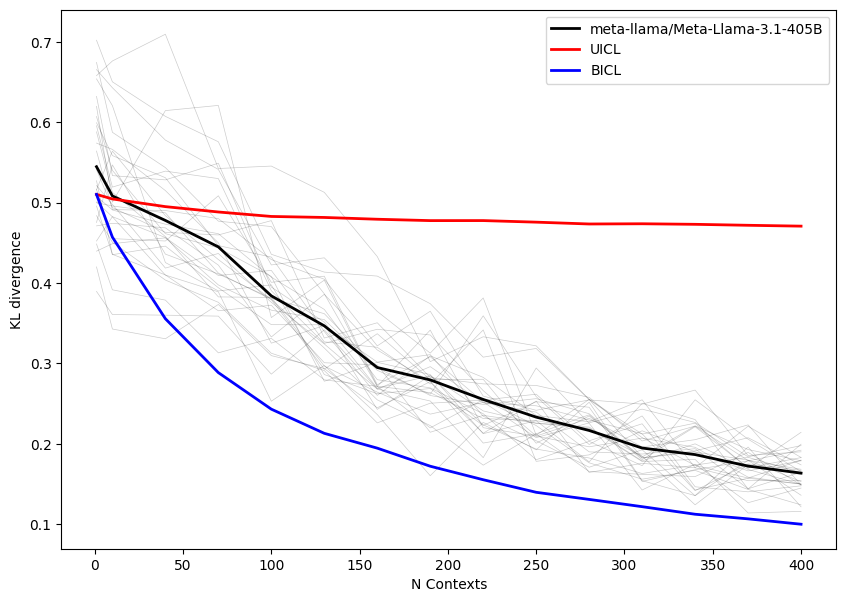

In [14]:
fig=plt.figure(figsize=(10,7))
plt.plot(n_contexts,kls.mean(0),c="k",lw=2,label=model_name)
for i in range(kls.shape[0]):
    plt.plot(n_contexts,kls[i],alpha=0.2,c="k",lw=0.5)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()
data["fig"]=fig

In [15]:
torch.save(data,save_path)